In [32]:
import numpy as np
import pandas as pd
import string
import xgboost as xgb
import io
import nltk
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv", usecols=['id','text'])

In [4]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


### Feature importance.

In [68]:
train_w_features = pd.read_csv('../TP2/train_features.csv')
test_w_features = pd.read_csv('../TP2/test_features.csv')
keyword_features = pd.read_csv('../TP2/keyword_features.csv')
keyword_test_features = pd.read_csv('../TP2/keyword_test_features.csv')
train_processed_text = pd.read_csv('../TP2/processed_train.csv')
test_processed_text = pd.read_csv('../TP2/processed_test.csv')

train_w_features.insert(3,'target',train_processed_text['target'])
train_features_and_kw = train_w_features.merge(keyword_features, on='id')
train_features_and_kw.insert(3,'processed_text', train_processed_text['text'])

test_features_and_kw = test_w_features.merge(keyword_test_features, on='id')
test_features_and_kw.insert(3,'processed_text', test_processed_text['text'])

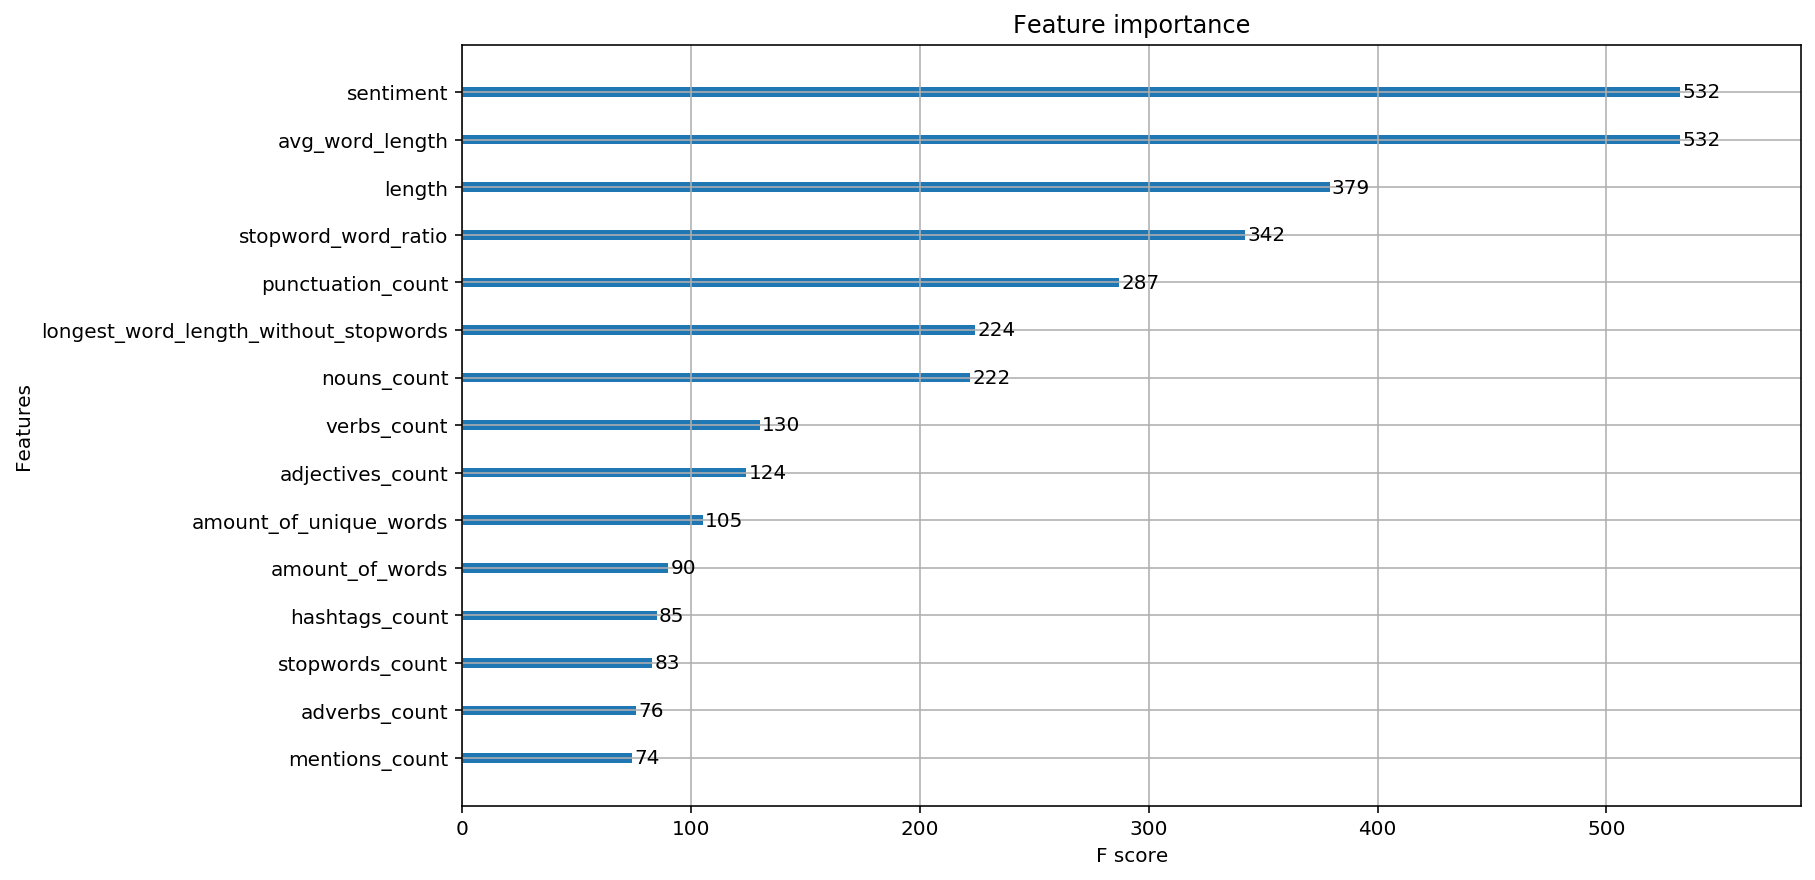

In [65]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
#Feature Importance de features de texto
x = train_w_features.loc[:,'length':]
y = train_w_features['target']
model = XGBClassifier()
model.fit(x, y)
pyplot.rcParams['figure.figsize'] = [12, 7]
plot_importance(model)
pyplot.show()

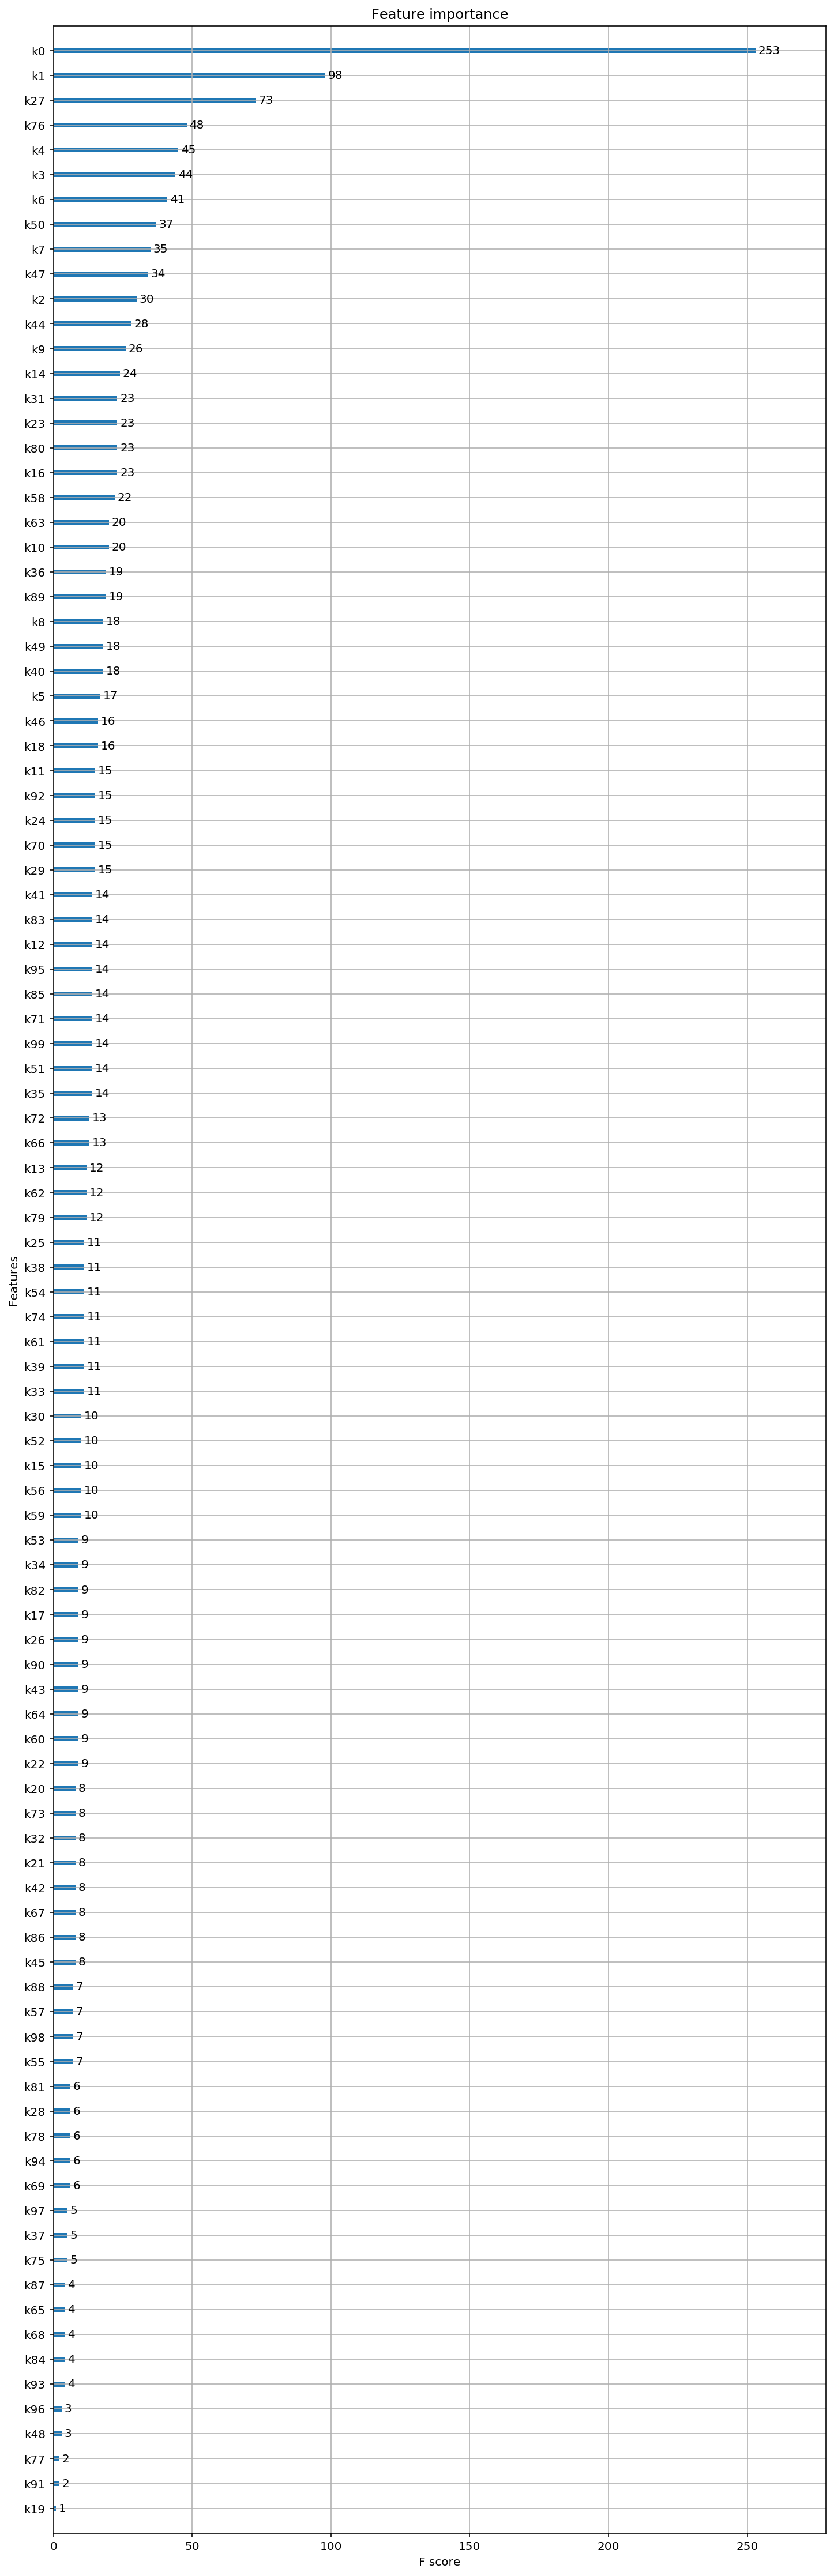

In [43]:
#Feature Importance de keywords
x = keyword_features.loc[:,'k0':]
y = train_w_features['target']
model = XGBClassifier()
model.fit(x, y)
pyplot.rcParams['figure.figsize'] = [12, 40]
plot_importance(model)
pyplot.show()

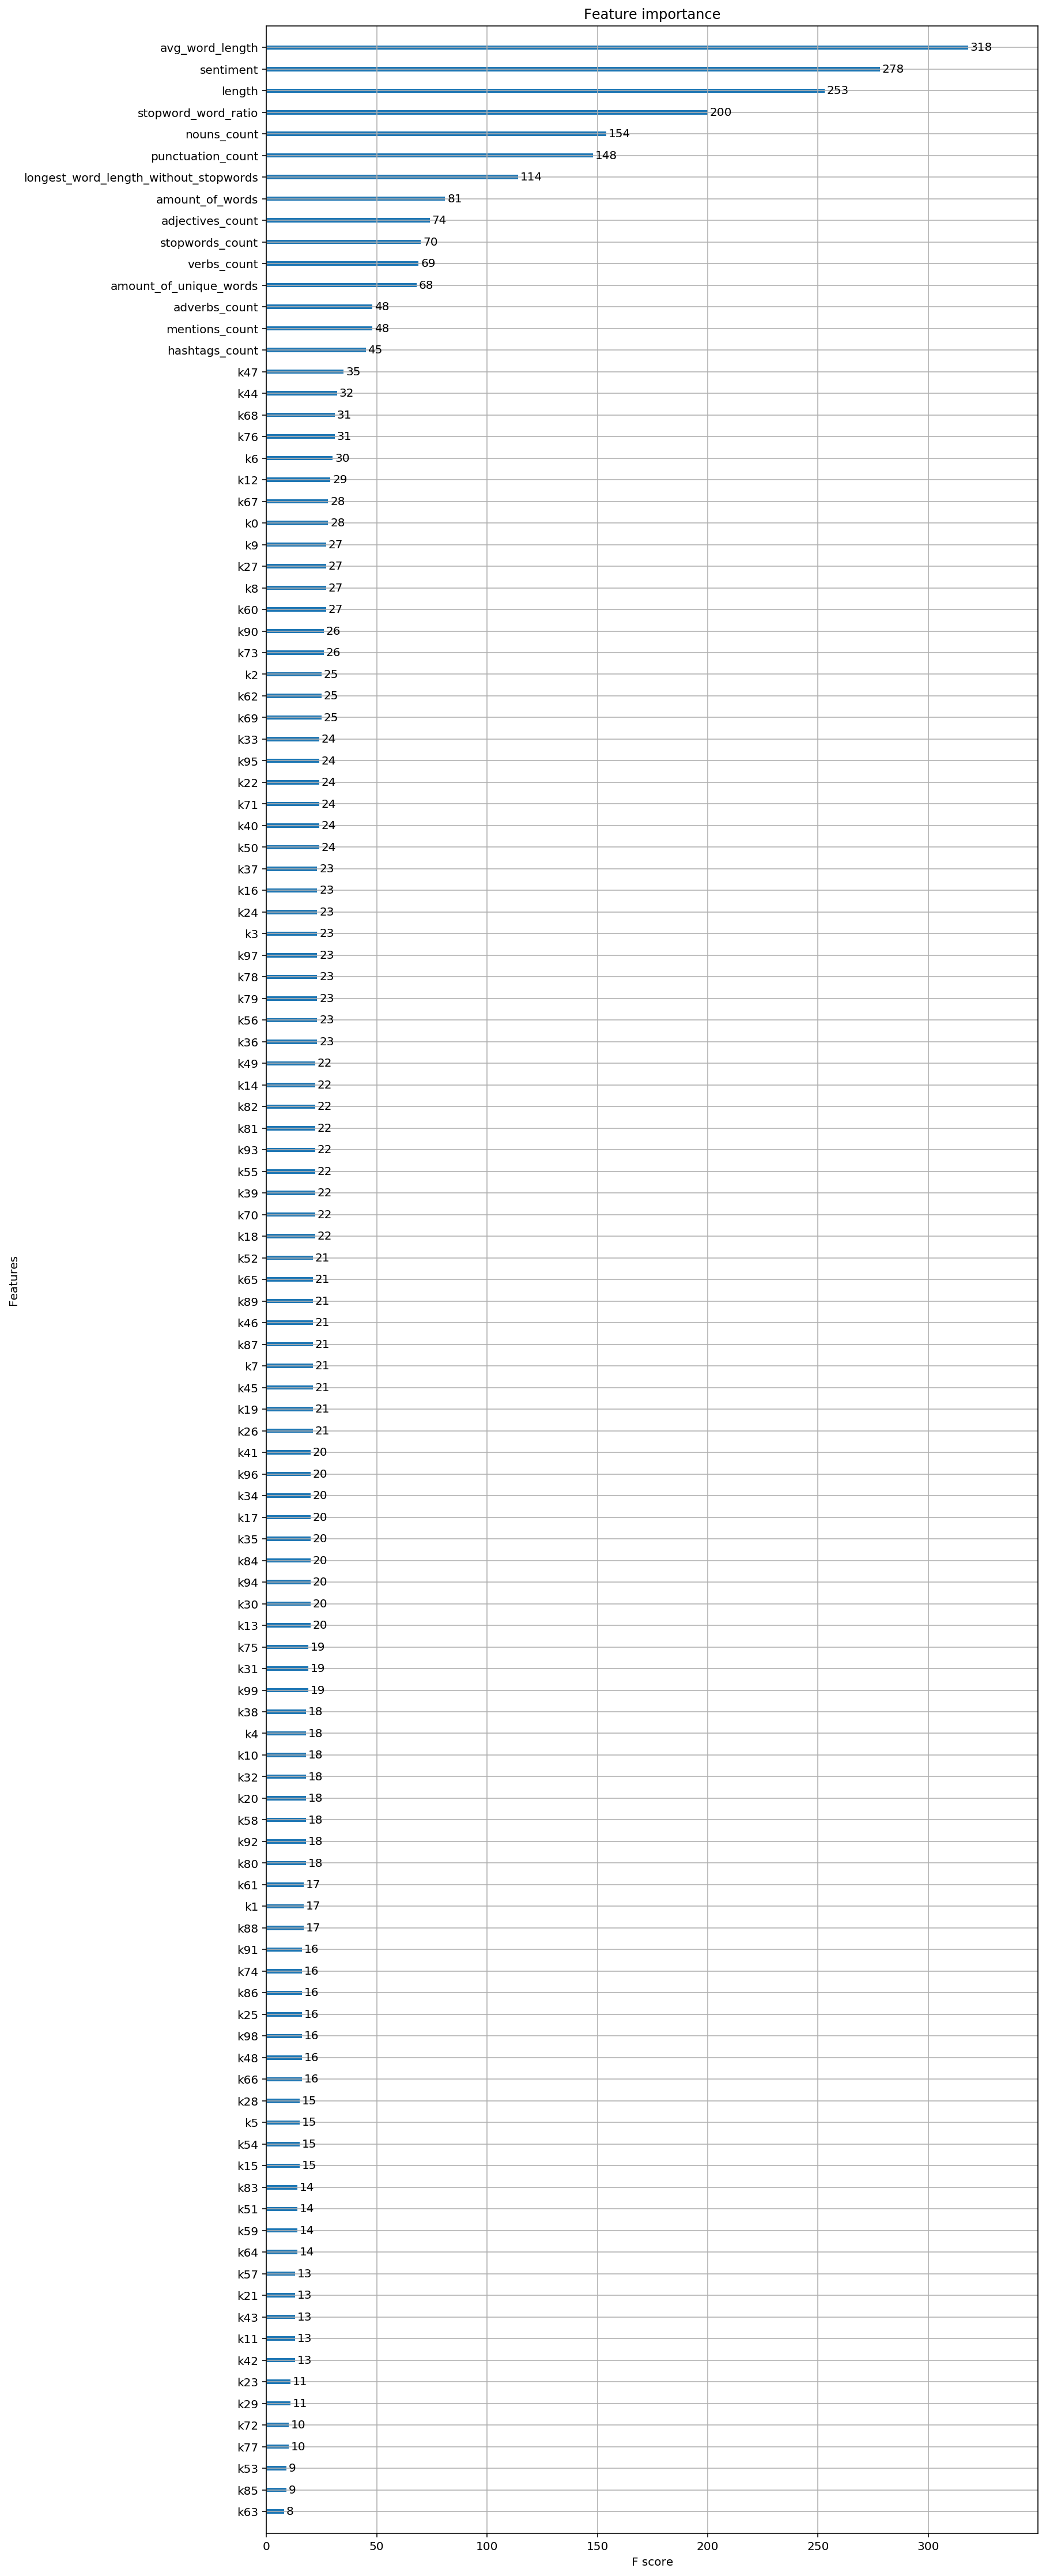

In [70]:
#Feature Importance de features completos
x = train_features_and_kw.loc[:,'length':]
y = train_features_and_kw['target']
model = XGBClassifier()
model.fit(x, y)
pyplot.rcParams['figure.figsize'] = [12, 40]
plot_importance(model)
pyplot.show()

### Evaluación de pre-trained words.

In [13]:
glove_embeddings = np.load('Embeddings/glove.840B.300d.pkl', allow_pickle=True)
fasttext_embeddings = np.load('Embeddings/crawl-300d-2M.pkl', allow_pickle=True)

In [15]:
import operator
def build_vocab(X):
    tweets = X.apply(lambda s: s.split()).values      
    vocab = {}
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

def check_embeddings_coverage(X, embeddings):
    vocab = build_vocab(X)    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(tweets_metrics['text'], glove_embeddings)
test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(test['text'], glove_embeddings)
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(tweets_metrics['text'], fasttext_embeddings)
test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(test['text'], fasttext_embeddings)
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 52.17% of vocabulary and 82.73% of text in Training Set
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set
FastText Embeddings cover 51.63% of vocabulary and 81.88% of text in Training Set
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set


In [33]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5652974442155101